This notebook aims to check why GLM detected the lightning emitted from the low cloud (cloud top height < 5 km).

In [1]:
import pandas as pd
from glob import glob
from satpy import Scene
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Read data

Two cases are selected: 2020-08-07 and 2020-08-27

In [2]:
abi_l1_dir = '../data/GOES-16/ABI_L1/'
abi_l2_dir = '../data/GOES-16/ABI_L2/'
glm_dir = '../data/GOES-16/GLM_L2_Grid/2km/'
entln_dir = '../data/ENGLN/'

case = '240'  # 233 (2020-08-07) or 240 (2020-08-27)

In [3]:
if case == '233':
    scn_abi_l1 = Scene(glob(abi_l1_dir+'OR_ABI-L1b-RadC-M6C13_G16_s20202331216*'), reader='abi_l1b')
    scn_abi_l2 = Scene(glob(abi_l2_dir+'OR_ABI-L2-ACHAC-M6_G16_s20202331216*'), reader='abi_l2_nc')
    scn_glm = Scene(glob(glm_dir+'OR_GLM-L2-GLMC-M3_G16_s20202331215*'), reader='glm_l2')

    df_entln = pd.read_csv(entln_dir+'xin_CONUS_flash20200807.csv')
    df_entln.index = pd.to_datetime(df_entln.timestamp)
    df_entln.loc['2020-08-07 12:10': '2020-08-07 12:30']

elif case == '240':
    scn_abi_l1 = Scene(glob(abi_l1_dir+'OR_ABI-L1b-RadC-M6C13_G16_s20202400006*'), reader='abi_l1b')
    scn_abi_l2 = Scene(glob(abi_l2_dir+'OR_ABI-L2-ACHAC-M6_G16_s20202400006*'), reader='abi_l2_nc')
    scn_glm = Scene(glob(glm_dir+'OR_GLM-L2-GLMC-M3_G16_s20202400005*'), reader='glm_l2')
    
    df_entln = pd.read_csv(entln_dir+'xin_CONUS_flash20200827.csv')
    df_entln.index = pd.to_datetime(df_entln.timestamp)
    df_entln = df_entln.loc['2020-08-27 00:00': '2020-08-27 00:20']
    # df_entln = df_entln[df_entln['type']==1]

scn_abi_l1.load(['C13'])
scn_abi_l2.load(['HT'])
scn_abi_l2['HT'] /= 1e3
scn_glm.load(['flash_extent_density', 'minimum_flash_area'])

/tmp/ipykernel_27980/4186564440.py:17: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_entln = df_entln.loc['2020-08-27 00:00': '2020-08-27 00:20']


## Plot

In [4]:
def plot_data(ax, scn, varname, extent=[-135, -108, 20, 28], plot_polygon=True):
    crs = scn[varname].area.to_cartopy_crs()
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    # ax.set_extent([-135, -70, 20, 50], crs=ccrs.PlateCarree())

    if varname == 'C13':
        title = 'TBB'
        cbar_label = '(K)'
        vmin = 180
        vmax = 320
    elif varname == 'HT':
        title = 'CTH'
        cbar_label = '(km)'
        vmin = 0
        vmax = 15
    elif varname == 'flash_extent_density':
        title = 'FED'
        cbar_label ='(flashes/5min)'
        vmin = 0
        vmax = 5
    elif varname == 'minimum_flash_area':
        title = 'MFA'
        cbar_label ='(km$^2$)'
        vmin = 0
        vmax = 1e3

    plt.imshow(scn[varname], transform=crs,
               extent=crs.bounds, origin='upper',
               vmin=vmin, vmax=vmax,
               cmap='viridis')

    cbar = plt.colorbar()
    cbar.set_label(cbar_label, fontsize=12)

    if plot_polygon:
        add_polygon(ax)
    
    ax.scatter(df_entln['longitude'], df_entln['latitude'],
               transform=ccrs.PlateCarree(), color='orange',
               s=6)
    
    ax.set_title(title, fontsize=15)

def add_polygon(ax):
    ax.add_patch(mpatches.Rectangle(xy=[-116.5, 25.5], width=2, height=1,
                 # mpatches.Rectangle(xy=[-116.5, 24], width=2, height=2,
                                    facecolor='None',
                                    edgecolor='red',
                                    alpha=0.5,
                                    transform=ccrs.PlateCarree())
                 )

def plot_abc(ax, label):
    ax.text(0, 1.05, label, transform=ax.transAxes, size=13, weight='bold', fontname='TeX Gyre Heros')

In [5]:
# font = {'size': 15}
# import matplotlib
# matplotlib.rc('font', **font)

/public/home/zhangxin/new/miniconda3/envs/pyresample_min/lib/python3.8/site-packages/pyproj/crs/crs.py:1216: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


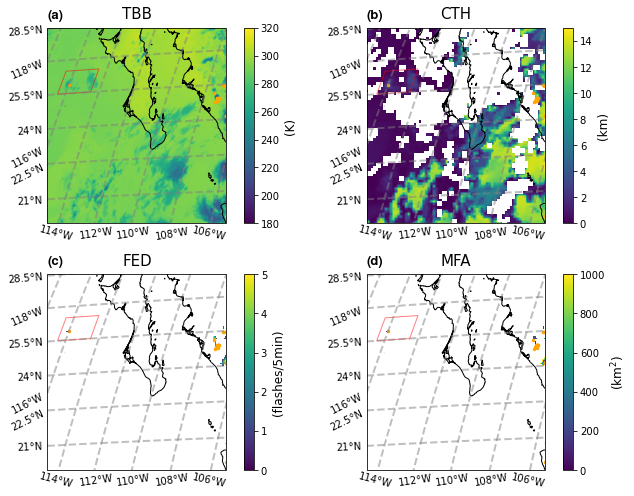

In [6]:
fig = plt.figure(figsize=(10, 7))

# --- abi ----
crs = scn_abi_l1['C13'].area.to_cartopy_crs()
ax = fig.add_subplot(2, 2, 1, projection=crs)
plot_data(ax, scn_abi_l1, 'C13')
plot_abc(ax, '(a)')

# ---- HT ----
crs = scn_abi_l2['HT'].area.to_cartopy_crs()
ax = fig.add_subplot(2, 2, 2, projection=crs)
plot_data(ax, scn_abi_l2, 'HT')
plot_abc(ax, '(b)')

# ---- glm ----
crs = scn_glm['flash_extent_density'].area.to_cartopy_crs()
ax = fig.add_subplot(2, 2, 3, projection=crs)
plot_data(ax, scn_glm, 'flash_extent_density')
plot_abc(ax, '(c)')

# ---- MFA ----
crs = scn_glm['minimum_flash_area'].area.to_cartopy_crs()
ax = fig.add_subplot(2, 2, 4, projection=crs)
plot_data(ax, scn_glm, 'minimum_flash_area')
plot_abc(ax, '(d)')

# plt.tight_layout(pad=0)
fig.tight_layout()
plt.subplots_adjust(wspace=-0.1)

fig.savefig('../figures/low_cth.png', dpi=600)

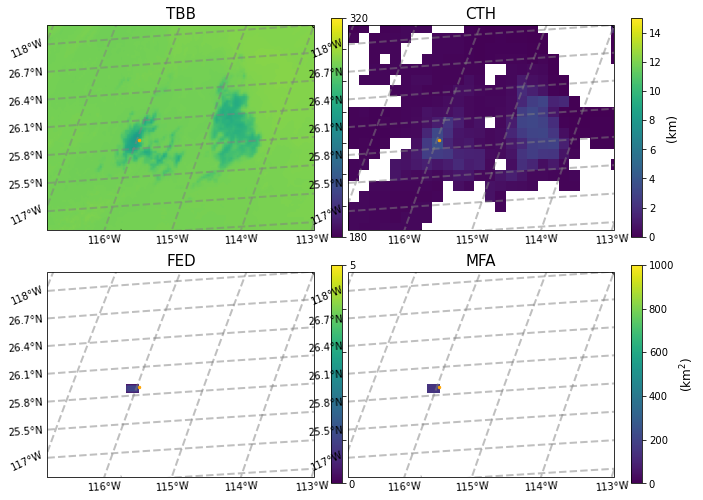

In [7]:
fig = plt.figure(figsize=(10, 7))

# --- abi ----
crs = scn_abi_l1['C13'].area.to_cartopy_crs()
ax = fig.add_subplot(2, 2, 1, projection=crs)
plot_data(ax, scn_abi_l1, 'C13', extent=[-118, -114, 25, 27], plot_polygon=False)

# ---- HT ----
crs = scn_abi_l2['HT'].area.to_cartopy_crs()
ax = fig.add_subplot(2, 2, 2, projection=crs)
plot_data(ax, scn_abi_l2, 'HT', extent=[-118, -114, 25, 27], plot_polygon=False)

# ---- glm ----
crs = scn_glm['flash_extent_density'].area.to_cartopy_crs()
ax = fig.add_subplot(2, 2, 3, projection=crs)
plot_data(ax, scn_glm, 'flash_extent_density', extent=[-118, -114, 25, 27], plot_polygon=False)

# ---- MFA ----
crs = scn_glm['minimum_flash_area'].area.to_cartopy_crs()
ax = fig.add_subplot(2, 2, 4, projection=crs)
plot_data(ax, scn_glm, 'minimum_flash_area', extent=[-118, -114, 25, 27], plot_polygon=False)

# plt.tight_layout(pad=0)
fig.tight_layout()
plt.subplots_adjust(wspace=-0.1)
# fig.savefig('../figures/low_cth.png', dpi=600)

So, it sounds reasonable as ENTLN also detected the lightning!